In [ ]:
import numpy as np
from scipy.special import ndtr


# ------------------------
# Analytical Bounds
# ------------------------

def ABound(K,Q,sigma,bQam,d,Metric):

    if bQam:
       q = int(np.sqrt(Q))
    else:
      q = Q

    M = K * (q - 1) + 1
    er = 0
    # MSE bound from Propostion 2
    if Metric == 'MSE':
       for i in range(1, M):
           er += (2*i-1 + (3*i*(1-i)-1)/M) * (1 - ndtr((2 * i - 1) * d / sigma))
       Bound = 2*(Q*bQam+1)*er
    # MAE bound from Propostion 3
    if Metric == 'MAE':
       for i in range(1, M):
            er += (1 + (1 - 2 * i) / M) * (1 - ndtr((2 * i - 1) * d / sigma))
       Bound = 2*(q*bQam+1)*er
    return Bound



# ------------------------
# Emprical Bounds
# ------------------------



# Emprical MAE bound
def Emprical_Bound(K,Q,sigma,bQam,square,Metric,Repeat=100):
    if bQam:
      q = int(np.sqrt(Q))
    else:
      q = Q

    e = 0
    for it in range(Repeat):
        # Noise of channel
        n = np.random.randn(1 + bQam) * sigma
        # Generting input signal uniform randomly
        if square:
          X = np.random.randint(q, size=K) + 1
          X = np.square(X)
        else:
          X = np.random.randint(Q, size=K) +1
        # Encoding
        Y = encoder(X, q, bQam)

        # AWGN Channel
        W = Y + n

        # Decoding
        yhat = round(W[0])
        if bQam:
           yhat =  yhat + round(W[1]) * q

        # Calculating thw Error
        y = X.sum()
        if Metric=='MSE':
           e = abs(y - yhat)**2  + e
        if Metric=='MAE':
           e = abs(y - yhat)  + e
    return e / Repeat


# ------------------------
# Encoders and Decoders
# ------------------------

# SumComp encoder
def encoder(g, q2,bQam):
    L = len(g)
    if bQam:
      z = np.zeros((2, L))
      for idx in range(L):
          z[0, idx] = g[idx] - q2 * np.floor(g[idx] / q2)
          z[1, idx] = np.floor(g[idx] / q2)
      z = z.sum(axis=bQam)
    else:
      z = g.sum(axis=bQam)
    return z


def EncoderSum(x,Q,step):
  if step ==1:
     C = int(np.sqrt(Q))
  else:
     C = Q
  cx =step*x
  return np.array([idx-C*np.floor(idx/C) + 1j*(np.floor(idx/C))   for idx in cx])


def EncoderComp(x,ModVec):
  return  np.array([ModVec[idx-1] for idx in x])

def EncoderOFDMA(x,ModVec):
  xcoded = np.array([ModVec[idx-1] for idx in x])
  return np.expand_dims(xcoded, axis=0)


# Channel Comp decoder

def DecoderOFDMA(array, value):

    array = np.asarray(array)
    y = []
    for val in value:
        idx = (np.abs(array - val)).argmin()
        y.append(idx + 1)
    return y

def DecoderComp(array, value):
    array = np.asarray(array)
    #idx = (np.abs(array - value)).argmin()
    return (np.abs(array - value)).argmin()

# Channel Sum decoder

def DecoderSum(value,Q,K,step):
    if step ==1:
      C = int(np.sqrt(Q))
    else:
      C = Q
    dim1 = np.round(np.real(value))
    if dim1 >= K*(C-1): dim1 = K*(C-1)
    if dim1 <=0: dim1 = 0

    dim2 = np.round(np.imag(value))

    if dim2 >= K*(C-1): dim2 =K*(C-1)
    if dim2 <= 0: dim2 = 0

    return (dim1 + dim2*C)/step



# Emprical Normalized MSE bound
def ENMSE(K,Q,sigma,method,phi,Repeat=100):
    nmse=0
    alpha = (1+1j)/np.sqrt(2)
    ModVec = [1+n for n in range(Q)]
    MeanVec = np.mean(ModVec)
    ModVec = ModVec - MeanVec
    for it in range(Repeat):

        Df = random.sample(phi, K)
        # Encoding
        if method =='ChannelComp':
            x = EncoderComp(Df,ModVec)
            n = np.random.normal(0,1) * sigma
        if method =='AirComp':
            x = Df
            n = np.random.normal(0,1) * sigma
        if method =='OFDMA':
            n = np.random.normal(0,sigma,K)*alpha
            x = EncoderOFDMA(Df,ModVec)
        if method =='SumComp':
            t = np.random.randn(2)*sigma   #np.random.normal(0,1)*alpha*sigma
            n = t[0] + 1j*t[1]
            Ct = int(np.sqrt(Q))
            x = np.array([idx-Ct*np.floor(idx/Ct) + 1j*(np.floor(idx/Ct))   for idx in Df])

        # AWGN Channel
        w = np.sum(x,axis=0) + n

        # Decoding
        if method =='ChannelComp':
             yhat = np.round(np.real(w)) + MeanVec*K
             yhat  = yhat/K
        if method =='AirComp':
             yhat = np.round(w)
             yhat  = yhat/K
        if method =='OFDMA':
             yhat = DecoderOFDMA(ModVec,w)
             yhat  = np.sum(yhat)/K
        if method =='SumComp':
             Ct = int(np.sqrt(Q))
             dim1 = np.round(np.real(w))
             dim2 = np.round(np.imag(w))
             yhat = dim1 + dim2*Ct
             yhat = yhat/K



        y = np.sum(Df)/K

        nmse = nmse + (np.abs(yhat-y)**2)/np.abs(y)

    return nmse / Repeat

# Emprical Normalized MSE bound for geometry


def ENMSEG(K,Q,sigma,method,phi,Repeat=100):
    nmse=0
    alpha = (1+1j)/np.sqrt(2)
    ModVec = np.array([3.4098 - 4.1264j, 0.2021 - 2.7743j,-1.3992 - 1.4617j,-2.7764 - 0.3204j, -2.6599 + 0.7654j,-1.6303 + 1.7480j,0.5336 + 2.6582j,4.3184 + 3.5113j]).astype(complex)
    MeanVec = np.mean(ModVec)
    ModVec = ModVec - MeanVec
    for it in range(Repeat):

        Df = random.sample(phi, K)
        # Encoding
        if method =='ChannelComp':
            x = EncoderComp(Df,ModVec)
            n = np.random.normal(0,1) *alpha* sigma
        if method =='AirComp':
            x = np.log2(Df)
            n = np.random.normal(0,1) * sigma
        if method =='OFDMA':
            n = np.random.normal(0,sigma,K)*alpha
            x = EncoderOFDMA(Df,ModVec)
        if method =='SumComp':
            step = 2*Q
            n = np.random.normal(0,1)*alpha*sigma
            xcoded = np.log2(Df)
            x = EncoderSum(xcoded,Q,step)
        # AWGN Channel
        w = np.sum(x,axis=0) + n

        # Decoding
        if method =='ChannelComp':
             ind_min = DecoderComp(Tab, w)
             yhat = Rf[ind_min]
        if method =='AirComp':
             yhat = 2**(np.real(w))
        if method =='OFDMA':
             yhat = DecoderOFDMA(ModVec,w)
             yhat  = np.prod(yhat)
        if method =='SumComp':
             step = 2*Q
             ydecod = DecoderSum(w,Q,K,step)
             ydecod = 2**(ydecod)
             yhat = np.round(ydecod)

        yhat  = yhat**(1/K)
        y = np.prod(Df)
        y = y**(1/K)

        nmse = nmse + (np.abs(yhat-y)**2)/np.abs(y)

    return nmse / Repeat


# MSE Error for QAM and PAM Figure 5

<ipython-input-17-231e1e5c4cab>:109: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(SNR_db, 10 * np.log10(MSES1[:]), '^')  # convert MSE to dB scale for plot
<ipython-input-17-231e1e5c4cab>:110: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(SNR_db, 10 * np.log10(MSET1[:]), '^-')  # convert MSE to dB scale for plot
<ipython-input-17-231e1e5c4cab>:111: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(SNR_db, 10 * np.log10(MSES2[:]), '<')  # convert MSE to dB scale for plot
<ipython-input-17-231e1e5c4cab>:112: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(SNR_db, 10 * np.log10(MSET2[:]), '<-')  # convert MSE to dB scale for plot
<ipython-input-17-231e1e5c4cab>:113: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(SNR_db, 10 * np.log10(MSES3[:]), '>')  # convert MSE to dB scale for plot
<ipython-input-17-231e1e5c4cab>:114: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(SNR_db, 10

<Figure size 640x480 with 0 Axes>

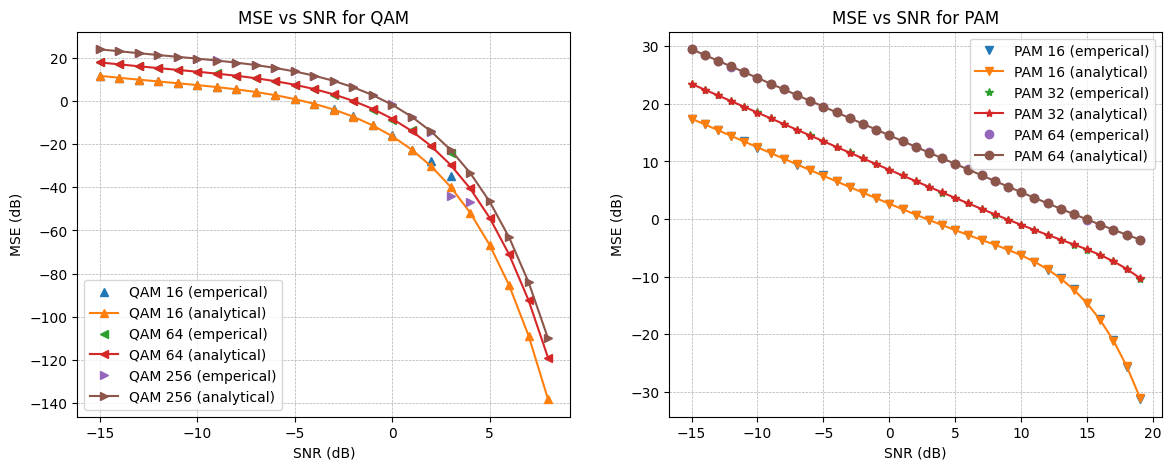

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define constants
Q1_QAM = 16  # sample value for q
Q2_QAM = 64  # sample value for q
Q3_QAM = 256  # sample value for q

Q1_PAM = 16  # sample value for q
Q2_PAM = 32  # sample value for q
Q3_PAM = 64  # sample value for q


Repeat = 50000 #100000

# Define SNR range in dB
SNR_db = np.arange(-15, 20, 1)  # range from -15 dB to 20 dB

# Define K range
K = 100

# Initialize MSE array
MSET1 = np.zeros(len(SNR_db))
MSET2 = np.zeros(len(SNR_db))
MSET3 = np.zeros(len(SNR_db))
MSET4 = np.zeros(len(SNR_db))
MSET5 = np.zeros(len(SNR_db))
MSET6 = np.zeros(len(SNR_db))

MSES1 = np.zeros(len(SNR_db))
MSES2 = np.zeros(len(SNR_db))
MSES3 = np.zeros(len(SNR_db))
MSES4 = np.zeros(len(SNR_db))
MSES5 = np.zeros(len(SNR_db))
MSES6 = np.zeros(len(SNR_db))

# QAM power normalaized one  : Meghdadi, Vahid. "BER calculation." Wireless Communications (2008).

P1 = (Q1_QAM-1)/6
P2 = (Q2_QAM-1)/6
P3 = (Q3_QAM-1)/6

# PAM Modulation

P4 = (Q1_PAM**2-1)/12
P5 = (Q2_PAM**2-1)/12
P6 = (Q3_PAM**2-1)/12


# Average over constellation points

P1 =P1/Q1_QAM
P2 =P2/Q2_QAM
P3 =P3/Q3_QAM

P4 = P4/Q1_PAM
P5 = P5/Q2_PAM
P6 = P6/Q3_PAM



d = abs(1) /2

nCount = 0
for snr in SNR_db:

    sigma1 = P1*10 **(-snr / 20)  # convert SNR to sigma
    sigma2 = P2*10 **(-snr / 20)  # convert SNR to sigma
    sigma3 = P3*10 **(-snr / 20)  # convert SNR to sigma

    sigma4 = P4*10 **(-snr / 20)  # convert SNR to sigma
    sigma5 = P5*10 **(-snr / 20)  # convert SNR to sigma
    sigma6 = P6*10 **(-snr / 20)  # convert SNR to sigma
    #---------------------
    # Emprical bound
    #---------------------
    bQam = 1
    MSES1[nCount] = Emprical_Bound(K,Q1_QAM,sigma1,bQam,0,'MSE',Repeat)
    MSES2[nCount] = Emprical_Bound(K,Q2_QAM,sigma2,bQam,0,'MSE',Repeat)
    MSES3[nCount] = Emprical_Bound(K,Q3_QAM,sigma3,bQam,0,'MSE',Repeat)

    bQam = 0
    MSES4[nCount] = Emprical_Bound(K,Q1_PAM,sigma4,bQam,0,'MSE',Repeat)
    MSES5[nCount] = Emprical_Bound(K,Q2_PAM,sigma5,bQam,0,'MSE',Repeat)
    MSES6[nCount] = Emprical_Bound(K,Q3_PAM,sigma6,bQam,0,'MSE',Repeat)

    #---------------------
    # Theoretical bound
    #---------------------
    bQam = 1
    MSET1[nCount] =ABound(K,Q1_QAM,sigma1,bQam,d,'MSE')
    MSET2[nCount] =ABound(K,Q2_QAM,sigma2,bQam,d,'MSE')
    MSET3[nCount] =ABound(K,Q3_QAM,sigma3,bQam,d,'MSE')

    bQam = 0
    MSET4[nCount] =ABound(K,Q1_PAM,sigma4,bQam,d,'MSE')
    MSET5[nCount] =ABound(K,Q2_PAM,sigma5,bQam,d,'MSE')
    MSET6[nCount] =ABound(K,Q3_PAM,sigma6,bQam,d,'MSE')

    nCount = nCount + 1


# Plot MSE vs SNR for each K
plt.figure()
fig, axs = plt.subplots(1, 2,figsize = (14,5))


axs[0].plot(SNR_db, 10 * np.log10(MSES1[:]), '^')  # convert MSE to dB scale for plot
axs[0].plot(SNR_db, 10 * np.log10(MSET1[:]), '^-')  # convert MSE to dB scale for plot
axs[0].plot(SNR_db, 10 * np.log10(MSES2[:]), '<')  # convert MSE to dB scale for plot
axs[0].plot(SNR_db, 10 * np.log10(MSET2[:]), '<-')  # convert MSE to dB scale for plot
axs[0].plot(SNR_db, 10 * np.log10(MSES3[:]), '>')  # convert MSE to dB scale for plot
axs[0].plot(SNR_db, 10 * np.log10(MSET3[:]), '>-')  # convert MSE to dB scale for plot

axs[0].set(xlabel='SNR (dB)')
axs[0].set(ylabel='MSE (dB)')
axs[0].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
axs[0].set(title='MSE vs SNR for QAM')
axs[0].legend(['QAM 16 (emperical)','QAM 16 (analytical)','QAM 64 (emperical)','QAM 64 (analytical)','QAM 256 (emperical)','QAM 256 (analytical)'])


axs[1].plot(SNR_db, 10 * np.log10(MSES4[:]), 'v')  # convert MSE to dB scale for plot
axs[1].plot(SNR_db, 10 * np.log10(MSET4[:]), 'v-')  # convert MSE to dB scale for plot
axs[1].plot(SNR_db, 10 * np.log10(MSES5[:]), '*')  # convert MSE to dB scale for plot
axs[1].plot(SNR_db, 10 * np.log10(MSET5[:]), '*-')  # convert MSE to dB scale for plot
axs[1].plot(SNR_db, 10 * np.log10(MSES6[:]), 'o')  # convert MSE to dB scale for plot
axs[1].plot(SNR_db, 10 * np.log10(MSET6[:]), 'o-')  # convert MSE to dB scale for plot

axs[1].set(xlabel='SNR (dB)')
axs[1].set(ylabel='MSE (dB)')
axs[1].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
axs[1].set(title='MSE vs SNR for PAM')
axs[1].legend(['PAM 16 (emperical)','PAM 16 (analytical)','PAM 32 (emperical)','PAM 32 (analytical)','PAM 64 (emperical)','PAM 64 (analytical)'])




MSEChannel = pd.DataFrame({'SNR': SNR_db,'MSES1': MSES1,'MSET1': MSET1,'MSES2': MSES2,'MSET2': MSET2,'MSES3': MSES3,'MSET3': MSET3, 'MSES4': MSES4,'MSET4': MSET4,'MSES5': MSES5,'MSET5': MSET5,'MSES6': MSES6,'MSET6': MSET6})
MSEChannel.set_index('SNR')

MSEChannel.to_csv('MSEError.dat',index=False,sep=' ')

# MAE for QAM and PAM 64 Figure 6

<ipython-input-18-0dbd24843fe2>:84: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(SNR_db, 10 * np.log10(MAES1[:]), '*')  # convert MSE to dB scale for plot
<ipython-input-18-0dbd24843fe2>:85: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(SNR_db, 10 * np.log10(MAET1[:]), '*-')  # convert MSE to dB scale for plot
<ipython-input-18-0dbd24843fe2>:97: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(SNR_db, 10 * np.log10(MAES3[:]), '*')  # convert MSE to dB scale for plot
<ipython-input-18-0dbd24843fe2>:98: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(SNR_db, 10 * np.log10(MAET3[:]), '*-')  # convert MSE to dB scale for plot
<ipython-input-18-0dbd24843fe2>:99: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(SNR_db, 10 * np.log10(MAES4[:]), 'o')  # convert MSE to dB scale for plot
<ipython-input-18-0dbd24843fe2>:100: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(SNR_db, 10 * np

<Figure size 640x480 with 0 Axes>

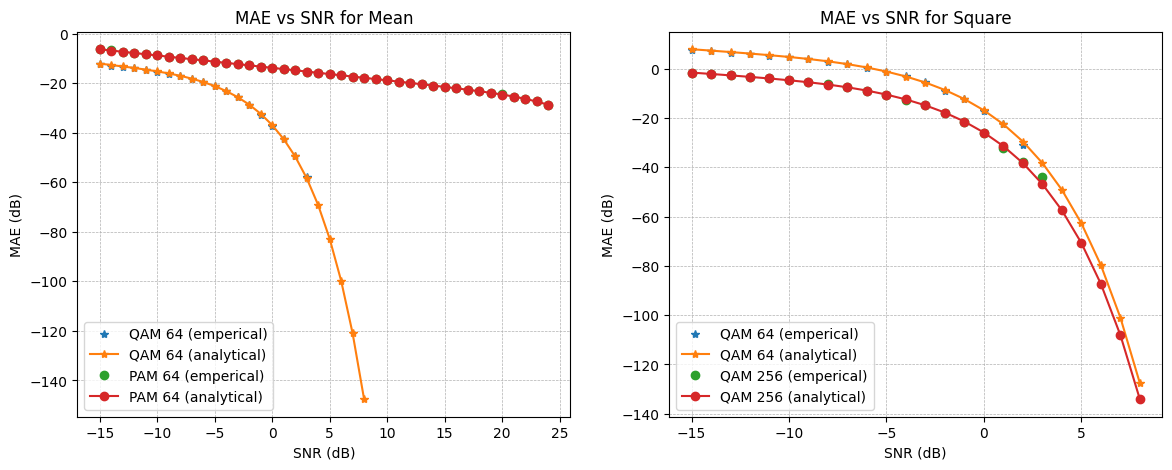

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define constants
Q1_QAM = 64  # sample value for  QAM
Q2_PAM = 64  # sample value for  PAM
Q3_QAM = 64  # sample value for  QAM
Q4_QAM = 256  # sample value for  PAM



Repeat = 50000 #100000

# Define SNR range in dB
SNR_db = np.arange(-15, 25, 1)  # range from -15 dB to 20 dB
# SNR = 10 ** (SNR_db / 10)  # convert from dB to linear scale
# Define K range
K = 100

# Initialize MSE array
MAET1 = np.zeros(len(SNR_db))
MAES1 = np.zeros(len(SNR_db))
MAET2 = np.zeros(len(SNR_db))
MAES2 = np.zeros(len(SNR_db))

MAET3 = np.zeros(len(SNR_db))
MAES3 = np.zeros(len(SNR_db))
MAET4 = np.zeros(len(SNR_db))
MAES4 = np.zeros(len(SNR_db))


P1 = (Q1_QAM-1)/6
P2 = (Q2_PAM**2-1)/12

P3 = (Q3_QAM-1)/6
P4 = (Q4_QAM-1)/6

# Average over constellation points

P1 = P1/Q1_QAM
P2 = P2/Q2_PAM
P3 = P3/Q3_QAM
P4 = P4/Q4_QAM




d = abs(1) /2

nCount = 0
for snr in SNR_db:
    sigma1 = P1*10 **(-snr / 20)  # convert SNR to sigma
    sigma2 = P2*10 **(-snr / 20)  # convert SNR to sigma
    sigma3 = P3*10 **(-snr / 20)  # convert SNR to sigma
    sigma4 = P4*10 **(-snr / 20)  # convert SNR to sigma

    #---------------------
    # Emprical bound
    #---------------------
    square = 0
    MAES1[nCount] = Emprical_Bound(K,Q1_QAM,sigma1,1,square,'MAE',Repeat)/K
    MAES2[nCount] = Emprical_Bound(K,Q2_PAM,sigma2,0,square,'MAE',Repeat)/K
    square = 1
    MAES3[nCount] = Emprical_Bound(K,Q3_QAM,sigma3,1,square,'MAE',Repeat)
    MAES4[nCount] = Emprical_Bound(K,Q4_QAM,sigma4,0,square,'MAE',Repeat)
    #---------------------
    # Theoretical bound
    #---------------------

    # Calculate MAE
    square = 0
    MAET1[nCount] =ABound(K,Q1_QAM,sigma1,1,d,'MAE')/K
    MAET2[nCount] =ABound(K,Q2_PAM,sigma2,0,d,'MAE')/K
    square = 1
    MAET3[nCount] = ABound(K,Q3_QAM,sigma3,1,d,'MAE')
    MAET4[nCount] = ABound(K,Q4_QAM,sigma4,0,d,'MAE')
    nCount = nCount + 1

# Plot MSE vs SNR for each K
plt.figure()
fig, axs = plt.subplots(1, 2,figsize = (14,5))

axs[0].plot(SNR_db, 10 * np.log10(MAES1[:]), '*')  # convert MSE to dB scale for plot
axs[0].plot(SNR_db, 10 * np.log10(MAET1[:]), '*-')  # convert MSE to dB scale for plot
axs[0].plot(SNR_db, 10 * np.log10(MAES2[:]), 'o')  # convert MSE to dB scale for plot
axs[0].plot(SNR_db, 10 * np.log10(MAET2[:]), 'o-')  # convert MSE to dB scale for plot
axs[0].set(xlabel='SNR (dB)')
axs[0].set(ylabel='MAE (dB)')
axs[0].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
axs[0].set(title='MAE vs SNR for Mean')
axs[0].legend(['QAM 64 (emperical)','QAM 64 (analytical)','PAM 64 (emperical)','PAM 64 (analytical)'])




axs[1].plot(SNR_db, 10 * np.log10(MAES3[:]), '*')  # convert MSE to dB scale for plot
axs[1].plot(SNR_db, 10 * np.log10(MAET3[:]), '*-')  # convert MSE to dB scale for plot
axs[1].plot(SNR_db, 10 * np.log10(MAES4[:]), 'o')  # convert MSE to dB scale for plot
axs[1].plot(SNR_db, 10 * np.log10(MAET4[:]), 'o-')  # convert MSE to dB scale for plot
axs[1].set(xlabel='SNR (dB)')
axs[1].set(ylabel='MAE (dB)')
axs[1].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
axs[1].set(title='MAE vs SNR for Square')
axs[1].legend(['QAM 64 (emperical)','QAM 64 (analytical)','QAM 256 (emperical)','QAM 256 (analytical)'])



MSEChannel = pd.DataFrame({'SNR': SNR_db,'MAES1': MAES1,'MAET1': MAET1,'MAES2': MAES2,'MAET2': MAET2,'MAES3': MAES3,'MAET3': MAET3,'MAES4': MAES4,'MAET4': MAET4})
MSEChannel.set_index('SNR')

MSEChannel.to_csv('MAEError.dat',index=False,sep=' ')

# Figure 7 Arithmatic Mean and Geometric Mean

<ipython-input-28-99ea6437e69f>:139: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(SNR, 10 * np.log10(ENMSE4[:]), 'o-')  # convert MSE to dB scale for plot
<ipython-input-28-99ea6437e69f>:151: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(SNR, 10 * np.log10(ENMSE7[:]), '*-')  # convert MSE to dB scale for plot


<Figure size 640x480 with 0 Axes>

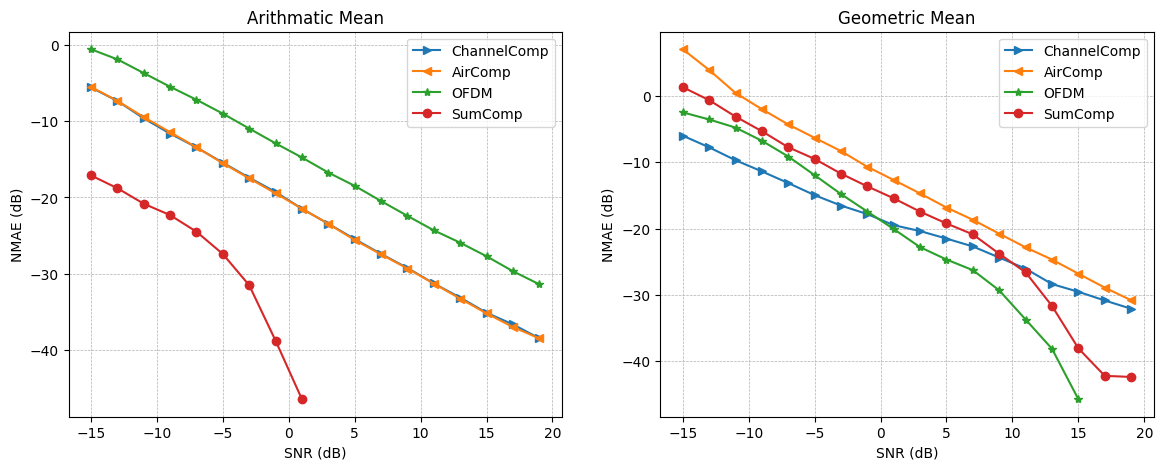

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from numpy.linalg import norm

Repeat = 50000 # number of tested samples 50000 50K

# ----------------------------
#   Arithmatic Mean Function
# ----------------------------

Q_mean = 64
K_mean  = 10 # number of users
q_mean = int(np.sqrt(Q_mean))


phi_mean = [1+n for n in range(Q_mean)]



# Quantized domian
P1_mean = (Q_mean**2-1)/12  #norm(rv) PAM formula (Q**2-1)d**2/3 : Meghdadi, Vahid. "BER calculation." Wireless Communications (2008).
P2_mean = (Q_mean**2-1)/12  #norm(rv) PAM formula (Q**2-1)d**2/3 : Meghdadi, Vahid. "BER calculation." Wireless Communications (2008).
P3_mean = (Q_mean**2-1)/12
# QAM power
P4_mean = (Q_mean-1)/6 # QAM power normalaized one  : Meghdadi, Vahid. "BER calculation." Wireless Communications (2008).


P1_mean = P1_mean/Q_mean
P2_mean = P2_mean/Q_mean
P3_mean = P3_mean/Q_mean
P4_mean = P4_mean/Q_mean




# ----------------------------
#   Geometric Mean Function
# ----------------------------



ModVec = np.array([3.4098 - 4.1264j, 0.2021 - 2.7743j,-1.3992 - 1.4617j,-2.7764 - 0.3204j, -2.6599 + 0.7654j,-1.6303 + 1.7480j,0.5336 + 2.6582j,4.3184 + 3.5113j]).astype(complex)
MeanVec = np.mean(ModVec)
ModVec = ModVec - MeanVec


K_geom = 4 # number of nodes
Q_geom = 8
q_geom = int(np.log2(Q_geom))

phi_geom = [1+n for n in range(Q_geom)]

# Generating the Tabluar function
A_Df = [ele for ele in product(phi_geom, repeat = K_geom)]
Rf = np.zeros(Q_geom**K_geom)
for idx in range(Q_geom**K_geom):
  Rf[idx] = np.prod(A_Df[idx])

Tab = np.zeros(Q_geom**K_geom,dtype=np.complex_)
for idx in range(Q_geom**K_geom):
  temp = EncoderComp(A_Df[idx],ModVec)
  Tab[idx] = np.sum(temp)





P1_geom = norm(ModVec)
P2_geom = norm(np.log2(phi_geom))
P3_geom = norm(ModVec)
P4_geom =  (Q_geom**2-1)/6 #



P1_geom = P1_geom/Q_geom
P2_geom = P2_geom/Q_geom
P3_geom = P3_geom/Q_geom
P4_geom = P4_geom/Q_geom






SNR = [2*n -15 for n in range(18)]

ENMSE1 =  np.zeros(len(SNR))
ENMSE2 =  np.zeros(len(SNR))
ENMSE3 =  np.zeros(len(SNR))
ENMSE4 =  np.zeros(len(SNR))
ENMSE5 =  np.zeros(len(SNR))
ENMSE6 =  np.zeros(len(SNR))
ENMSE7 =  np.zeros(len(SNR))
ENMSE8 =  np.zeros(len(SNR))

nCount = 0
for snr in SNR:

    sigma1  = P1_mean*10 **(-snr / 20)
    sigma2  = P2_mean*10 **(-snr / 20)
    sigma3  = P3_mean*10 **(-snr / 20)
    sigma4  = P4_mean*10 **(-snr / 20)

    sigma5  = P1_geom*10 **(-snr / 20)
    sigma6  = P2_geom*10 **(-snr / 20)
    sigma7  = P3_geom*10 **(-snr / 20)
    sigma8  = P4_geom*10 **(-snr / 20)



    ENMSE1[nCount] = ENMSE(K_mean,Q_mean,sigma1,'ChannelComp',phi_mean,Repeat)
    ENMSE2[nCount] = ENMSE(K_mean,Q_mean,sigma2,'AirComp',phi_mean,Repeat)
    ENMSE3[nCount] = ENMSE(K_mean,Q_mean,sigma3,'OFDMA',phi_mean,Repeat)
    ENMSE4[nCount] = ENMSE(K_mean,Q_mean,sigma4,'SumComp',phi_mean,Repeat)


    ENMSE5[nCount] = ENMSEG(K_geom,Q_geom,sigma5,'ChannelComp',phi_geom,Repeat)
    ENMSE6[nCount] = ENMSEG(K_geom,Q_geom,sigma6,'AirComp',phi_geom,Repeat)
    ENMSE7[nCount] = ENMSEG(K_geom,Q_geom,sigma7,'OFDMA',phi_geom,Repeat)
    ENMSE8[nCount] = ENMSEG(K_geom,Q_geom,sigma8,'SumComp',phi_geom,Repeat)



    nCount= nCount + 1





plt.figure()
fig, axs = plt.subplots(1, 2,figsize = (14,5))

axs[0].plot(SNR, 10 * np.log10(ENMSE1[:]), '>-')  # convert MSE to dB scale for plot
axs[0].plot(SNR, 10 * np.log10(ENMSE2[:]), '<-')  # convert MSE to dB scale for plot
axs[0].plot(SNR, 10 * np.log10(ENMSE3[:]), '*-')  # convert MSE to dB scale for plot
axs[0].plot(SNR, 10 * np.log10(ENMSE4[:]), 'o-')  # convert MSE to dB scale for plot
axs[0].set(xlabel='SNR (dB)')
axs[0].set(ylabel='NMAE (dB)')
axs[0].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
axs[0].set(title='Arithmatic Mean')
axs[0].legend(['ChannelComp','AirComp','OFDM','SumComp'])




axs[1].plot(SNR, 10 * np.log10(ENMSE5[:]), '>-')  # convert MSE to dB scale for plot
axs[1].plot(SNR, 10 * np.log10(ENMSE6[:]), '<-')  # convert MSE to dB scale for plot
axs[1].plot(SNR, 10 * np.log10(ENMSE7[:]), '*-')  # convert MSE to dB scale for plot
axs[1].plot(SNR, 10 * np.log10(ENMSE8[:]), 'o-')  # convert MSE to dB scale for plot
axs[1].set(xlabel='SNR (dB)')
axs[1].set(ylabel='NMAE (dB)')
axs[1].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
axs[1].set(title='Geometric Mean')
axs[1].legend(['ChannelComp','AirComp','OFDM','SumComp'])





MSEChannel = pd.DataFrame({'SNR': SNR,'ChannelCompA': ENMSE1,'OATA': ENMSE2,'OFDMA': ENMSE3,'ChannelSumA': ENMSE4,'ChannelCompG': ENMSE5,'OATG': ENMSE6,'OFDMG': ENMSE7,'ChannelSumG': ENMSE8 })
MSEChannel.set_index('SNR')

MSEChannel.to_csv('NMSEerror.dat',index=False,sep=' ')

In [ ]:
SNR_db = np.arange(-15, 25, 1)
sigma4  = P4_mean*10 **(-snr / 20)

# Figure 8
Computing the Complexity

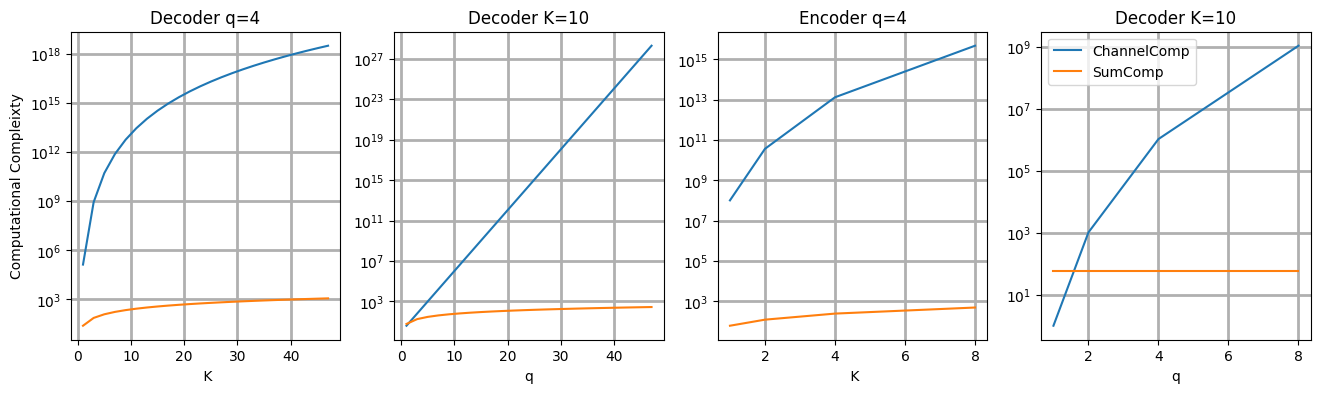

In [ ]:
# A and C
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# Different number of nodes
# ----------------------------
K = 24
q = 4
# Diffrent nodes
Km = [2*n+1 for n in range(K)]


# m = q**5*k**2
# Order of ChannelComp is O(K^3q^{2K+3}})
# CComp = [(k**3)*q**(2*k+3) for k in Km]

EChannelComp1 = [q**8.5*k**8  for k in Km]
ESumComp1 = [6*k*q for k in Km]

DChannelComp1 = [q**k  for k in Km]
DSumComp1 = [6*k for k in Km]



# ----------------------------
# Different quantization levels
# ----------------------------
K = 10
Q = 4
# Diffrent nodes
Qm = [2**n for n in range(Q)]


EChannelComp2 = [q**8.5*K**8  for q in Qm]
ESumComp2 = [6*K*q for q in Qm]

DChannelComp2 = [q**K  for q in Qm]
DSumComp2 = [6*K for q in Qm]




fig, axs = plt.subplots(1, 4,figsize = (16,4))


axs[0].plot(Km,EChannelComp1,Km,ESumComp1)
axs[0].set(yscale ="log")
axs[0].set(title ="Decoder q=4")
axs[0].set(xlabel = ' K')
axs[0].set(ylabel ='Computational Compleixty')
axs[0].grid( linestyle='-', which='major',linewidth=2)
axs[0].grid( linestyle='--', which='minor',linewidth=2)


axs[1].plot(Km,DChannelComp1,Km,DSumComp1)
axs[1].set(yscale ="log")
axs[1].set(title = "Decoder K=10")
axs[1].set(xlabel='q')
axs[1].grid( linestyle='-', which='major',linewidth=2)
axs[1].grid( linestyle='--', which='minor',linewidth=2)



axs[2].plot(Qm,EChannelComp2,Qm,ESumComp2)
axs[2].set(yscale ="log")
axs[2].set(xlabel=' K')
axs[2].set(title="Encoder q=4")
axs[2].grid( linestyle='-', which='major',linewidth=2)
axs[2].grid( linestyle='--', which='minor',linewidth=2)





axs[3].plot(Qm,DChannelComp2,Qm,DSumComp2)
axs[3].set(yscale ="log")
axs[3].set(xlabel= 'q')
axs[3].set(title= "Decoder K=10")
axs[3].legend(['ChannelComp','SumComp'])
axs[3].grid( linestyle='-', which='major',linewidth=2)
axs[3].grid( linestyle='--', which='minor',linewidth=2)




MSEChannel = pd.DataFrame({'K': Km,'EncodeChannelComp': EChannelComp1,'EncodeSumComp': ESumComp1,'DecodeChannelComp': DChannelComp1,'DecodeSumComp': DSumComp1 })
MSEChannel.set_index('K')

MSEChannel.to_csv('Complexity.dat',index=False,sep=' ')

MSEChannel = pd.DataFrame({'q': Qm,'EncodeChannelComp': EChannelComp2,'EncodeSumComp': ESumComp2,'DecodeChannelComp': DChannelComp2,'DecodeSumComp': DSumComp2 })
MSEChannel.set_index('q')

MSEChannel.to_csv('Complexity2.dat',index=False,sep=' ')
